# Exploratory analysis of ADNI2 longitudinal data
* **Objectives:** 
    1. Characterize symptom severity trajectories based on clinical assessments
    2. Map structural features onto symptoms


* **Input modalities:**
    1. Coritcal thickness (CT)
    2. Hippocampal subfield volumes (HC) 


* **Clinical scales: ADAS-13, MMSE**

In [ ]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import collections
from scipy import stats
import seaborn as sns
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

In [2]:
# Data imports
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
#adnimerge_file = 'ADNIMERGE.csv'
hc_vol_file = '/input_csv/adni2-qcvols_nodups.csv'
CT_file = 'input_csv/ADNI2_subject_ROI_CT_dict_AAL.csv'
hc_data = pd.read_csv(baseline_dir + hc_vol_file)
ct_data = pd.read_csv(baseline_dir + CT_file)
#print ct_data.columns

In [3]:
#HC + CT Merge
in_data = pd.merge(hc_data, ct_data, on='ImageUID',how='inner')
#in_data.to_csv(baseline_dir + 'adni2-qcvols_nodups_aal_ct.csv'



In [4]:
# Extract subset of columns and subjects (cohort)
cohort = 'ADNI2'
#demographics
col_list_demo = ['PTID','ImageUID','AGE','PTGENDER','APOE4']
data_demo  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_demo]

#add a column with numerical DX mapping
in_data['DX_cat'] = in_data['DX'].replace(['MCI to NL', 'NL'], 0)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to MCI', 'MCI', 'Dementia to MCI'], 1)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to Dementia','MCI to Dementia', 'Dementia'], 2)
in_data['DX_cat'].values.astype(float)


# features / variables
clinical_feat = ['PTID','DX','DX_cat','ADAS13','MMSE']
hc_feat = ['L_CA1','L_subiculum','L_CA4DG','L_CA2CA3','L_stratum','L_Alv','L_Fimb','L_Fornix','L_Mam',
                 'R_CA1','R_subiculum','R_CA4DG','R_CA2CA3','R_stratum','R_Alv','R_Fimb','R_Fornix','R_Mam']
ct_feat = ['AAL_1', 'AAL_2', 'AAL_3','AAL_4', 'AAL_5', 'AAL_6', 'AAL_7', 'AAL_8', 'AAL_9', 'AAL_10',
                 'AAL_11', 'AAL_12', 'AAL_13', 'AAL_14', 'AAL_15', 'AAL_16', 'AAL_17', 'AAL_18', 'AAL_19', 'AAL_20', 
                 'AAL_21', 'AAL_22', 'AAL_23', 'AAL_24', 'AAL_25', 'AAL_26', 'AAL_27', 'AAL_28', 'AAL_29', 'AAL_30', 
                 'AAL_31', 'AAL_32', 'AAL_33', 'AAL_34', 'AAL_35', 'AAL_36', 'AAL_39', 'AAL_40', 'AAL_43', 'AAL_44', 
                 'AAL_45', 'AAL_46', 'AAL_47', 'AAL_48', 'AAL_49', 'AAL_50', 'AAL_51', 'AAL_52', 'AAL_53', 'AAL_54',
                 'AAL_55', 'AAL_56', 'AAL_57', 'AAL_58', 'AAL_59', 'AAL_60', 'AAL_61', 'AAL_62', 'AAL_63', 'AAL_64', 
                 'AAL_65', 'AAL_66', 'AAL_67', 'AAL_68', 'AAL_69', 'AAL_70', 'AAL_79', 'AAL_80', 'AAL_81', 'AAL_82',
                 'AAL_83', 'AAL_84', 'AAL_85', 'AAL_86', 'AAL_87', 'AAL_88', 'AAL_89', 'AAL_90']

col_list_feat = clinical_feat + hc_feat + ct_feat

data_bl  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_feat]
#data_bl = data_bl.drop_duplicates(subset='PTID', keep='first')
data_m03 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm03')][col_list_feat]
#data_m03 = data_m03.drop_duplicates(subset='PTID', keep='first')
data_m06 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm06')][col_list_feat]
#data_m06 = data_m06.drop_duplicates(subset='PTID', keep='first')
data_m12 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm12')][col_list_feat]
#data_m12 = data_m12.drop_duplicates(subset='PTID', keep='first')
data_m24 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm24')][col_list_feat]
#data_m24 = data_m24.drop_duplicates(subset='PTID', keep='first')
data_m36 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm36')][col_list_feat]
data_m48 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm48')][col_list_feat]

print 'number of subjects [BL,m03,m06,m12,m24]: {}'.format([len(data_bl.PTID.values),len(data_m03.PTID.values),
                                                            len(data_m06.PTID.values),len(data_m12.PTID.values),
                                                            len(data_m24.PTID.values)])

number of subjects [BL,m03,m06,m12,m24]: [654, 547, 482, 485, 337]


In [7]:
#Count MCI subjects
bl_ptid = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')& (in_data.DX_cat == 1)]['PTID'].values
m06_ptid = in_data[(in_data.ORIGPROT == cohort) & (in_data.VISCODE == 'm06')]['PTID'].values
m12_ptid = in_data[(in_data.ORIGPROT == cohort) & (in_data.VISCODE == 'm12')]['PTID'].values
m24_ptid = in_data[(in_data.ORIGPROT == cohort) & (in_data.VISCODE == 'm24')]['PTID'].values

print len(bl_ptid),len(m06_ptid),len(m12_ptid),len(m24_ptid)

print len(set(bl_ptid) & set(m06_ptid) & set(m12_ptid) & set(m24_ptid))

278 487 489 342
162


In [6]:
# number of HC subjects: [698, 698, 588, 520, 522, 371]
# number of CT subjects: [654, 654, 547, 482, 485, 337]
# number of HC_CT subjects: [654, 654, 547, 482, 485, 337]

#Rename Columns and Merge into 1 table 
bl=[]
m03=[]
m06=[]
m12=[]
m24=[]

for col in col_list_feat:
    if col == 'PTID':
        bl.append('PTID')
        #m03.append('PTID')
        m06.append('PTID')
        m12.append('PTID')
        m24.append('PTID')
    else:
        bl.append(col+'_bl')
        #m03.append(col+'_m03')
        m06.append(col+'_m06')
        m12.append(col+'_m12')
        m24.append(col+'_m24')
            
data_bl.columns= bl
#data_m03.columns=m03
data_m06.columns=m06
data_m12.columns=m12
data_m24.columns=m24
        
test_merge = pd.merge(data_demo, data_bl, on='PTID',how='inner')
print '# bl: {}'.format(len(test_merge))

# Select subject subsets based on Dx at baseline
#drop AD and/or CN 
test_merge = test_merge[test_merge.DX_cat_bl != 2]
print '# bl (AD removed): {}'.format(len(test_merge))

#test_merge = pd.merge(test_merge, data_m03, on='PTID',how='inner')
#print len(test_merge)
test_merge = pd.merge(test_merge, data_m06, on='PTID',how='inner')
print '# 06: {}'.format(len(test_merge))
test_merge = pd.merge(test_merge, data_m12, on='PTID',how='inner')
print '# 12: {}'.format(len(test_merge))
test_merge = pd.merge(test_merge, data_m24, on='PTID',how='inner')
print '# 24: {}'.format(len(test_merge))

test_merge=test_merge.drop_duplicates(subset='PTID', keep='first')
print '# 24 (dups removed): {}'.format(len(test_merge))

test_merge.dropna(inplace=True)
print '# 24 (NANs removed): {}'.format(len(test_merge))

#add score diffs 
time_points = ['_m06','_m12','_m24']
for col in col_list_feat:
    for tp in time_points:
        if not col in ['PTID','DX']:
            val_diff = test_merge['{}{}'.format(col,tp)] - test_merge['{}_bl'.format(col)]
            test_merge['{}{}_diff'.format(col,tp)] = val_diff
            if col == 'ADAS13':
                test_merge['PointGain2{}'.format(tp)] = val_diff.values > 2
                test_merge['PointGain4{}'.format(tp)] = val_diff.values > 4
                test_merge['PointGain6{}'.format(tp)] = val_diff.values > 6
                test_merge['PointZero{}'.format(tp)] = val_diff.values > 0
                test_merge['PointLoss2{}'.format(tp)] = val_diff.values < -2
                test_merge['PointLoss4{}'.format(tp)] = val_diff.values < -4
                test_merge['PointLoss6{}'.format(tp)] = val_diff.values < -6
                test_merge['PointMod4{}'.format(tp)] = np.abs(val_diff.values) > 4                
            

print 'After _m06,_m12,_m24:'                
print '# 0+ PointGain: {},{},{}'.format(np.sum(test_merge['PointZero_m06'].values),np.sum(test_merge['PointZero_m12'].values), np.sum(test_merge['PointZero_m24'].values))
print '# 2+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain2_m06'].values), np.sum(test_merge['PointGain2_m12'].values), np.sum(test_merge['PointGain2_m24'].values))
print '# 4+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain4_m06'].values), np.sum(test_merge['PointGain4_m12'].values), np.sum(test_merge['PointGain4_m24'].values))
print '# 6+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain6_m06'].values), np.sum(test_merge['PointGain6_m12'].values), np.sum(test_merge['PointGain6_m24'].values))
print '# 2- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss2_m06'].values), np.sum(test_merge['PointLoss2_m12'].values), np.sum(test_merge['PointLoss2_m24'].values))
print '# 4- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss4_m06'].values), np.sum(test_merge['PointLoss4_m12'].values), np.sum(test_merge['PointLoss4_m24'].values))
print '# 6- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss6_m06'].values), np.sum(test_merge['PointLoss6_m12'].values), np.sum(test_merge['PointLoss6_m24'].values))
print '# 4 Point abs change: {},{},{}'.format(np.sum(test_merge['PointMod4_m06'].values), np.sum(test_merge['PointMod4_m12'].values), np.sum(test_merge['PointMod4_m24'].values))

# bl: 654
# bl (AD removed): 528
# 06: 384
# 12: 353
# 24: 267
# 24 (dups removed): 267
# 24 (NANs removed): 257
After _m06,_m12,_m24:
# 0+ PointGain: 111,99,115
# 2+ PointGain: 64,61,81
# 4+ PointGain: 24,28,48
# 6+ PointGain: 12,7,27
# 2- PointLoss: 69,85,74
# 4- PointLoss: 41,49,41
# 6- PointLoss: 18,21,16
# 4 Point abs change: 65,77,89


In [9]:
np.set_printoptions(precision=3)
age = test_merge.AGE.values
sex = test_merge.PTGENDER.values
adas = test_merge.ADAS13_bl.values
apoe = test_merge.APOE4.values

print len(test_merge), len(age), np.mean(age),np.std(age), np.sum(sex=='Male'),np.sum(sex=='Female'), np.mean(adas),np.std(adas)

print np.sum(apoe==0),np.sum(apoe==1),np.sum(apoe==2), np.sum(apoe!=-1)

test_merge.columns

156 156 70.9717948718 6.91494845701 82 74 15.5064102564 6.77523468689
72 65 19 156


Index([u'PTID', u'ImageUID', u'AGE', u'PTGENDER', u'APOE4', u'DX_bl',
       u'DX_cat_bl', u'ADAS13_bl', u'MMSE_bl', u'L_CA1_bl',
       ...
       u'AAL_87_m24_diff', u'AAL_88_m06_diff', u'AAL_88_m12_diff',
       u'AAL_88_m24_diff', u'AAL_89_m06_diff', u'AAL_89_m12_diff',
       u'AAL_89_m24_diff', u'AAL_90_m06_diff', u'AAL_90_m12_diff',
       u'AAL_90_m24_diff'],
      dtype='object', length=726)

## Subject similarity based clustering 

* **Objective** 
    1. Group subjects toegther to identify individuals in congnitve decline from stable. 


* **Method: hierarchical clustering** 
    1. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
    2. seaborn: http://seaborn.pydata.org/generated/seaborn.clustermap.html?highlight=clustermap#seaborn.clustermap


* **Similarity metric**
    1. Correlation between ADAS score timeseries ([BL, m06, m12, m18])
    
    
* **Things to consider**
    1. Number of clusters
    2. Effect of baseline Dx
    2. Effect of clustering parameters (linkage etc.) 


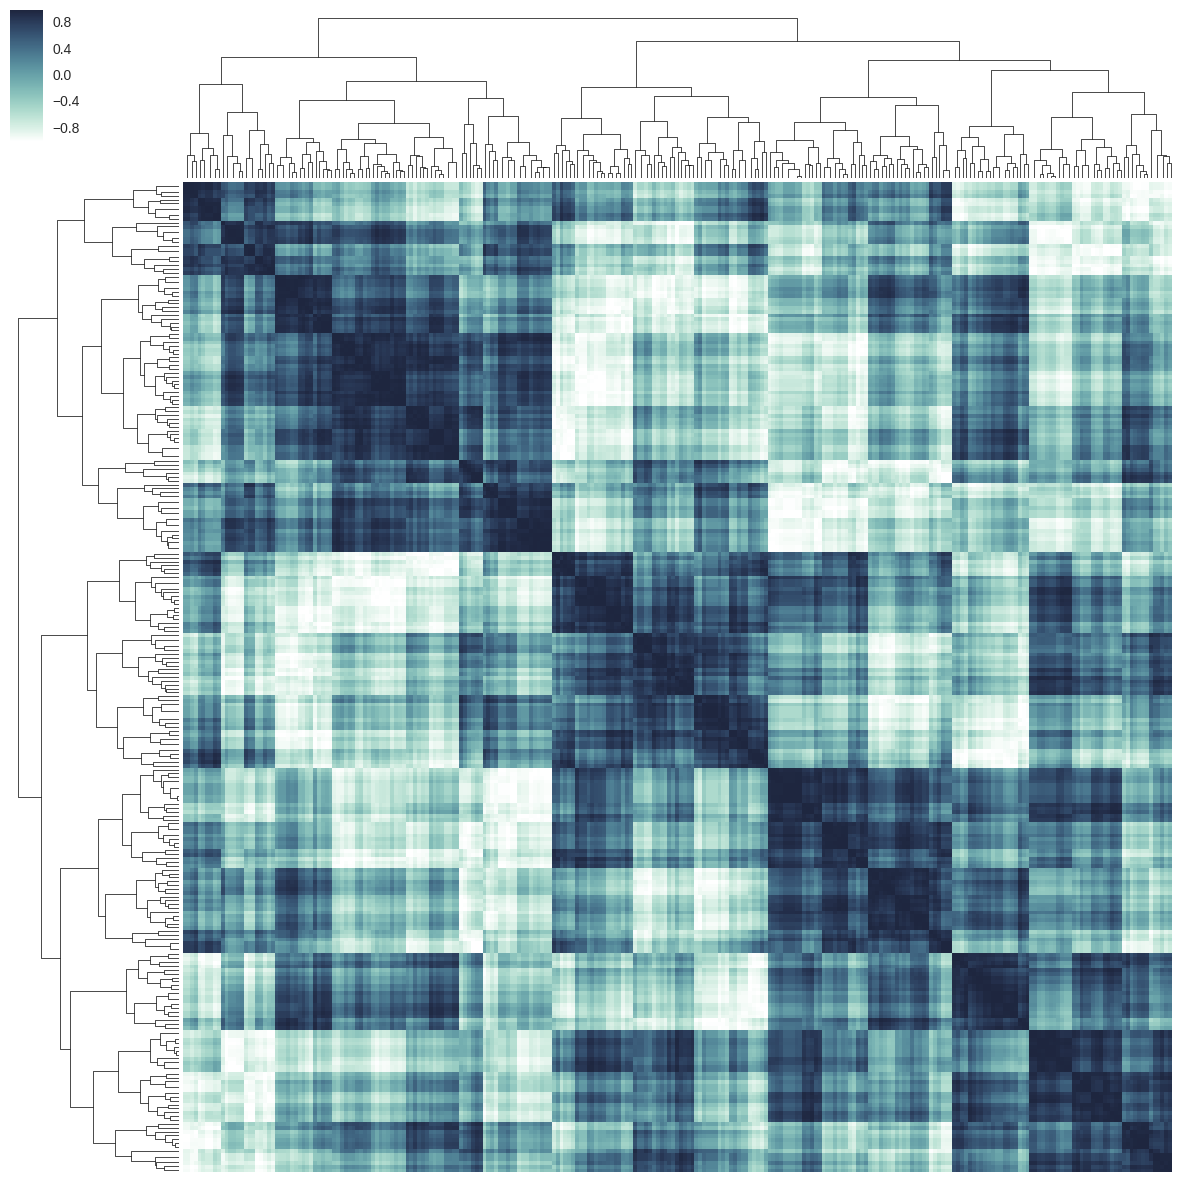

In [7]:
# Intersubject correlations (no CV loop)
sns.set(style="white")
save_figure = False

CS_cols = ['ADAS13_bl','ADAS13_m06','ADAS13_m12','ADAS13_m24']
#CS_cols = ['MMSE_bl','MMSE_m06','MMSE_m12','MMSE_m24']

d = pd.DataFrame(data=np.transpose(test_merge[CS_cols].values),
                 index = CS_cols,
                 columns=test_merge['PTID'].values)

# Compute the correlation matrix
corr = d.corr()
#corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints (for MMSE)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.clustermap(data=corr, annot=True, cmap='Greens')
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

g = sns.clustermap(corr, method='average', cmap=cmap, figsize=(15, 15),xticklabels=False,yticklabels=False)
#plt.xlabel('Hierarchical Clustering of MCI subject based on correlation of clinical score progression')

    
if save_figure:
    fig_name = 'hclust_MCI.jpg'
    g.savefig(baseline_dir + fig_name, format='jpeg', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)


In [11]:
#save cluster memberships
import scipy.cluster.hierarchy as sch
num_of_clusters = 4
Z = g.dendrogram_col.linkage
#Z = linkage(d.transpose(),method='average',metric='correlation')
T = sch.fcluster(Z, num_of_clusters, 'maxclust')
print np.sum(T==1),np.sum(T==2),np.sum(T==3),np.sum(T==4)


24 72 56 105


In [128]:
# Intersubject correlations
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as sch
sns.set(style="white")
save_figure = False

CS_cols = ['ADAS13_bl','ADAS13_m06','ADAS13_m12','ADAS13_m24']
#CS_cols = ['MMSE_bl','MMSE_m06','MMSE_m12','MMSE_m24']

clust_df = test_merge[CS_cols]

kf = KFold(n_splits=10)

df_traj_concat = pd.DataFrame(columns=['score','timepoint','trajectory_class','KF'])
for i, (train, test) in enumerate(kf.split(clust_df.index)):
    #print i, (train, test)
    train_df = clust_df.iloc[train]
    d = pd.DataFrame(data=np.transpose(train_df.values),
                     index = CS_cols,
                     columns=test_merge['PTID'].values[train])

    # Compute the correlation matrix
    corr = d.corr()


    corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints (for MMSE)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    #sns.clustermap(data=corr, annot=True, cmap='Greens')
    cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

    #g = sns.clustermap(corr, method='average', cmap=cmap, figsize=(5, 5),xticklabels=False,yticklabels=False)
    #g = sns.clustermap(corr, method='ward', cmap=cmap, figsize=(5, 5),xticklabels=False,yticklabels=False)
    
    #save cluster memberships
    num_of_clusters = 2
    #Z = g.dendrogram_col.linkage
    Z = linkage(d.transpose(),method='average',metric='correlation')
    T = sch.fcluster(Z, num_of_clusters, 'maxclust')
    #print np.sum(T==1),np.sum(T==2)
    #print T.shape, d.values.shape

    tpx, subx = d.values.shape
    score_vec = d.transpose().values.reshape(tpx*subx,1).astype(np.float)
    tp_vec = np.tile([0,6,12,24],subx).reshape(tpx*subx,1)
    T_tp = np.repeat(T,4, axis=0).reshape(tpx*subx,1)
    fid_vec = np.tile(i,tpx*subx).reshape(tpx*subx,1)
    ptid_vec = np.repeat(test_merge['PTID'].values[train],4, axis=0).reshape(tpx*subx,1)
    
    #df_traj = pd.DataFrame(data = np.hstack((ptid_vec,score_vec,tp_vec,T_tp,fid_vec)), columns=['PTID','score','timepoint','trajectory_class','KF'])
    df_traj = pd.DataFrame(data = np.hstack((score_vec,tp_vec,T_tp,fid_vec)), columns=['score','timepoint','trajectory_class','KF'])
    df_traj_concat=df_traj_concat.append(df_traj,ignore_index=True)

In [129]:
#Stability stats for clusters
traj_dist_df = df_traj_concat[df_traj_concat.timepoint==0]

traj_permute_stats = pd.DataFrame(columns=['PTID','T1_percent','T2_percent'])
for i, ptid in enumerate(test_merge.PTID.values):
    traj_list = traj_dist_df[traj_dist_df.PTID == ptid]['trajectory_class'].values 
    t1_percent = np.sum(traj_list==1)/float(len(traj_list))
    t2_percent = np.sum(traj_list==2)/float(len(traj_list))
    traj_permute_stats.loc[i] = [ptid,t1_percent,t2_percent]
    
print 'number of subjects: {}'.format(len(traj_permute_stats))

AttributeError: 'DataFrame' object has no attribute 'PTID'

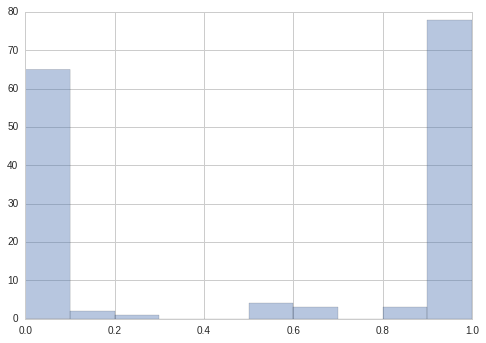

In [119]:
#Plot cluster memebership distribution per PTID
sns.set(style="whitegrid")
sns.distplot(traj_permute_stats['T2_percent'].values, kde=False, bins=10)

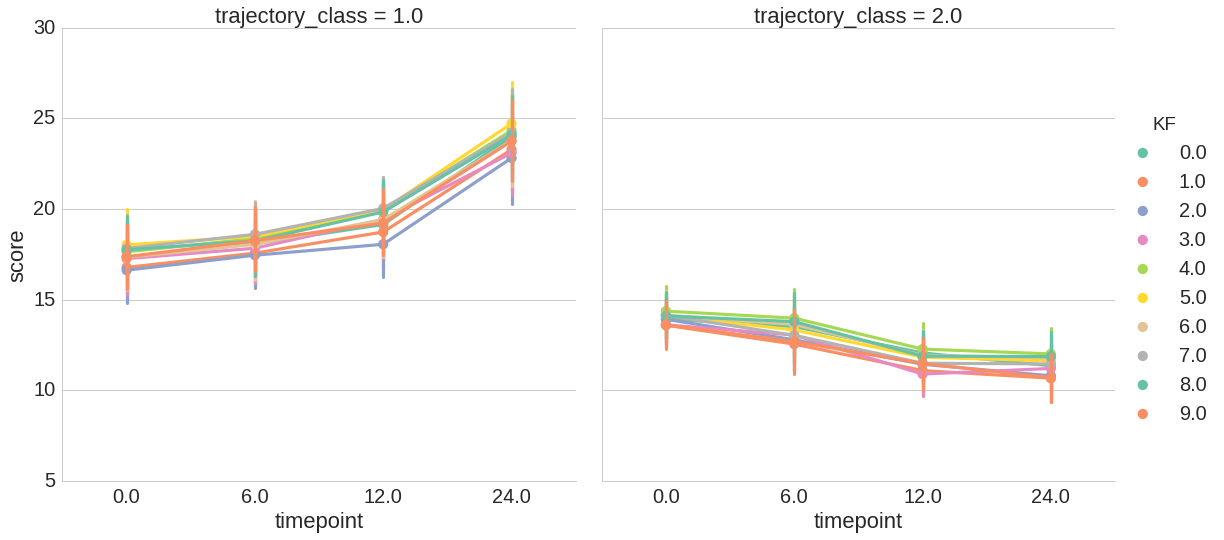

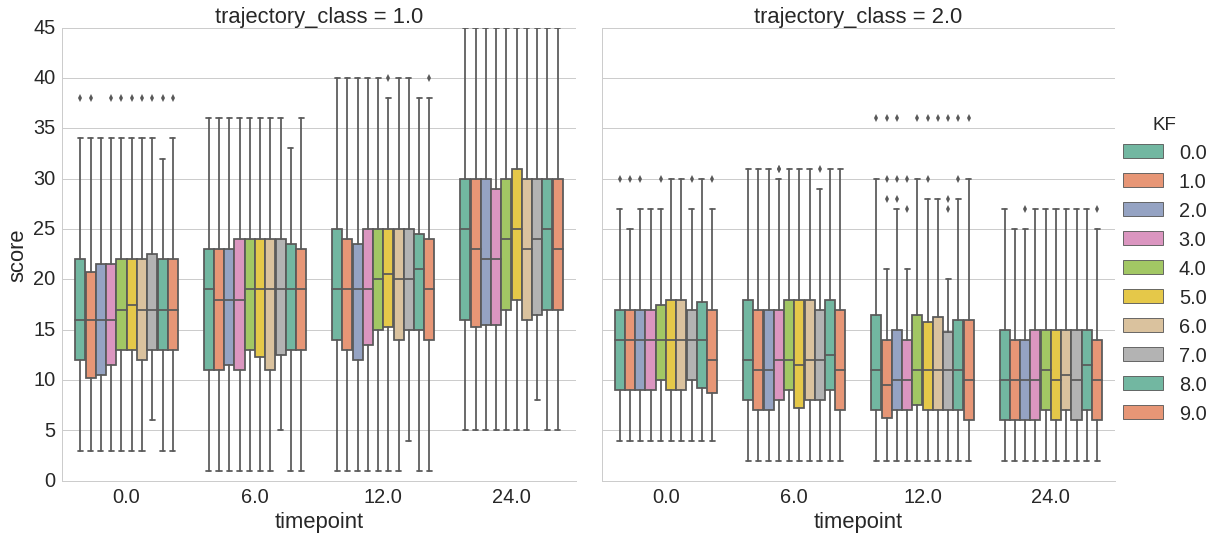

In [132]:
#plots
save_figure = False
sns.set(font_scale=2) 
sns.set_style("whitegrid")

g = sns.factorplot(x="timepoint", y='score', hue='KF',col='trajectory_class', kind='point', palette='Set2',data=df_traj_concat,size=8)
#plt.title('Mean score per time-point for each trajectory class')
g = sns.factorplot(x="timepoint", y='score', hue='KF',col='trajectory_class', kind='box', palette='Set2', data=df_traj_concat,size=8)
#plt.title('Score distibution per time-point for each trajectory class')

if save_figure:
    fig_name = 'Traj_score_distribution.jpg'
    g.savefig(baseline_dir + fig_name, format='jpeg', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)

In [ ]:
# Save subject - trajectry labels. 
#d.to_csv(baseline_dir+'input_csv/Longitduinal_MCI_ADAS13_traj_test.csv')

demo_df = test_merge[['PTID','PTGENDER','APOE4','ADAS13_bl','AGE']]
demo_df['traj'] = T
print len(demo_df)

for traj in [1,2]:
    sex = demo_df[demo_df.traj==traj].PTGENDER.values
    age = demo_df[demo_df.traj==traj].AGE.values
    apoe = demo_df[demo_df.traj==traj].APOE4.values
    adas = demo_df[demo_df.traj==traj].ADAS13_bl.values
    
    print np.sum(sex=='Male'),np.sum(sex=='Female'),np.mean(age), np.std(age),np.sum(apoe==0),np.sum(apoe==1),np.sum(apoe==2)
    print np.mean(adas), np.std(adas)

print 

#Statistical Significance
adas_T1 = demo_df[demo_df.traj==1].ADAS13_bl.values
adas_T2 = demo_df[demo_df.traj==2].ADAS13_bl.values

t_stat = stats.ttest_ind(adas_T1,adas_T2, equal_var = False)

print t_stat

In [ ]:
#plot individual trajectories
concat_df = pd.merge(demo_df, in_data[['PTID','VISCODE','DX','DX_cat','ADAS13','MMSE','AGE','PTGENDER','APOE4']+hc_feat],
                     on='PTID',how='inner')

concat_df.dropna(inplace=True)
print len(concat_df)

sns.set(font_scale=2) 
#sns.axes_style("whitegrid"):
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 20)

scores = test_merge[['ADAS13_bl','ADAS13_m06','ADAS13_m12','ADAS13_m24']].values

vol_list = []
mr_feat_list = ['CA1','subiculum','CA4DG','CA2CA3','stratum','Alv','Fimb','Fornix','Mam']
for mr_feat in mr_feat_list:
    L_vols = test_merge[['L_'+mr_feat+'_bl', 'L_'+mr_feat+'_m06', 'L_'+mr_feat+'_m12', 'L_'+mr_feat+'_m24']].values
    R_vols = test_merge[['R_'+mr_feat+'_bl', 'R_'+mr_feat+'_m06', 'R_'+mr_feat+'_m12', 'R_'+mr_feat+'_m24']].values
    vol_list.append(0.5*(L_vols+R_vols))
    
vols = np.sum(np.array(vol_list),axis=0)
T = test_merge.DX_cat_bl.values
my_colors = ["#2ecc71","#9b59b6","#34495e"]
for i in range(len(scores)):
    x = scores[i,:]
    y = vols[i,:]
    col_idx = int(T[i])
    plt.plot(x,y,'-o',c=my_colors[col_idx])
    
plt.xlabel('adas13')
plt.ylabel('HC_vol')
plt.title('Individual trajectories per Dx (CN,MCI,AD)')

In [20]:
# Import individual ADAS scores (Analysis of memory related task)
baseline_dir = '/projects/nikhil/ADNI_prediction/Clinical_Data/ADNI_2_GO/'
adas_scores_file = 'ADAS_ADNIGO2.csv'

adas_data = pd.read_csv(baseline_dir + adas_scores_file)

subject_info_cols = ['ID','RID','VISCODE','VISCODE2']
score_cols = []#['TOTAL13']
for i in range(13):
    score_cols.append('Q{}SCORE'.format(i+1))

adas_data_adni2 = adas_data[(adas_data.Phase == 'ADNI2') & (adas_data.VISCODE2.isin(['bl','m06','m12','m24','m48']))][subject_info_cols+score_cols]

print 'adas_data_adni2 length:{}'.format(len(adas_data_adni2))
adas_data_adni2_vstack = pd.DataFrame(columns=subject_info_cols+['SCORE','Q'])

for score in score_cols:
    df = adas_data_adni2[subject_info_cols]
    df['SCORE'] = adas_data_adni2[score].values
    df['Q'] = np.tile(score,len(adas_data_adni2[score].values))
    adas_data_adni2_vstack = adas_data_adni2_vstack.append(df,ignore_index=True)
    
print 'adas_data_adni2_vstack length:{}'.format(len(adas_data_adni2_vstack))
    


/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adas_data_adni2 length:2970
adas_data_adni2_vstack length:38610


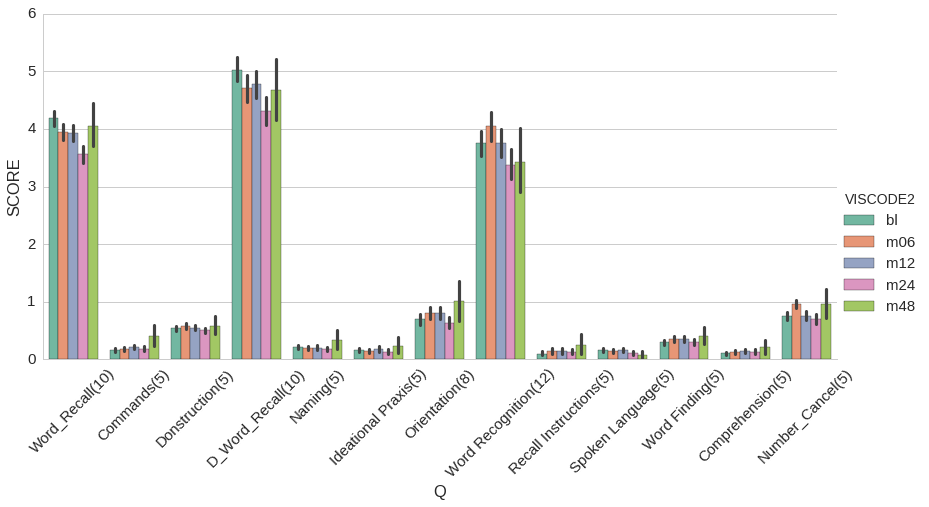

In [21]:
#plot individual Q stats
sns.set(font_scale=1.5) 
sns.set_style("whitegrid")
viscode_order = ['bl','m06','m12','m24','m48']
Q_names = ['Word_Recall(10)','Commands(5)','Donstruction(5)','D_Word_Recall(10)','Naming(5)','Ideational Praxis(5)',
           'Orientation(8)','Word Recognition(12)','Recall Instructions(5)','Spoken Language(5)','Word Finding(5)',
           'Comprehension(5)','Number_Cancel(5)']
adas_data_adni2_vstack.replace(score_cols,Q_names, inplace=True)

g = sns.factorplot(x="Q", y='SCORE', hue='VISCODE2', kind='bar', palette='Set2', size=6, aspect=2, 
                   hue_order=viscode_order, data=adas_data_adni2_vstack)
g.set_xticklabels(rotation=45)

## Feature clustering and correlations

* **Objectives** 
    1. Look at feature covariance / correlations  
    2. Look at correlation between symptoms and features over time


In [ ]:
# Compute the correlation matrix between features at baseline
mr_feat = []
for col in hc_feat + ct_feat:
    mr_feat.append(col+'_bl')

df = test_merge[mr_feat]
# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

# Draw the full plot
cg = sns.clustermap(df.corr(), linewidths=.5, figsize=(15, 15), cmap=cmap)
#plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [ ]:
#Feature - Score correlations over time
x = test_merge

feat_list = hc_feat #pick one: hc_feat or ct_feat
           
time_points_mr = ['_bl','_m06','_m12','_m24']
#time_points_cs = ['_m12','_m24']
time_points_cs = ['_m24','_m24','_m24','_m24']
corr_dict = {}
idx = 0
feat_grp_size = 9 #Esthetics - number of lines in the same plot. 
for f, feat in enumerate(feat_list):
    for tp_mr, tp_cs in zip(time_points_mr,time_points_cs):
        adas = test_merge['ADAS13'+tp_cs].values
        adas_clean = adas[np.isfinite(adas)]        
        y = test_merge[feat+tp_mr].values
        y = y[np.isfinite(adas)]
        adas_r = stats.pearsonr(y,adas_clean)[0]
        
        mmse = test_merge['MMSE'+tp_cs].values
        mmse_clean = mmse[np.isfinite(mmse)]        
        y = test_merge[feat+tp_mr].values
        y = y[np.isfinite(mmse)]
        mmse_r = stats.pearsonr(y,mmse_clean)[0]
        
        corr_dict[idx]={'structure':feat,'time-point':tp_mr,'adas_r':adas_r,'mmse_r':mmse_r,'feat_grp':f/feat_grp_size}
        idx += 1
    
df = pd.DataFrame.from_dict(corr_dict,orient='index')

sns.set_context("notebook", font_scale=1.25)
sns.set_style("ticks")
clinical_scale = 'adas_r'
if len(feat_list) == 18: #hc_feat
    g = sns.factorplot(x="time-point", y=clinical_scale, hue='structure', col='feat_grp', col_wrap=2,
                       markers=['o', 'd', 's','+', '^', '>', 'v', '<','x','o', 'd', 's','+', '^', '>', 'v', '<','x'],
                       data=df, size=5)
else: 
    g = sns.factorplot(x="time-point", y=clinical_scale, hue='structure', col='feat_grp', col_wrap=3, data=df, size=4)
g.despine(left=True)

#plt.title('Correlation between structural measure vs. clinical scores')
    

**Other exploratory analysis - in progress** 

In [ ]:
plt.rcParams['figure.figsize'] = (30, 40)
font_size = 10
from scipy.stats import ttest_ind

univar_measures = ['AGE','ADAS13_bl'] 
for feat in hc_feat:
    univar_measures.append(feat + '_bl')
    
cols = 6
rows = np.ceil(float(len(univar_measures))/cols)

for u, univar in enumerate(univar_measures):
    if univar in ['APOE4','PTGENDER']:
        univar_measure_cat = np.transpose(test_merge[univar].values)
    else:
        univar_measure_cat = np.transpose(test_merge[univar].values)
        
    dx_traj = np.transpose(np.vstack((univar_measure_cat, T)))
    dx_traj_df = pd.DataFrame(data=dx_traj, columns=[univar,'Traj'])
    
    
    if univar not in ['APOE4','PTGENDER']:
        cat1 = test_merge[univar].values[T==1]
        cat2 = test_merge[univar].values[T==2]

        print 'univar: {}, t_val:{:4.3f}, p_val:{:4.3f}'.format(univar, ttest_ind(cat1,cat2)[0],ttest_ind(cat1,cat2)[1])

        
    plt.subplot(rows,cols,u+1)
    sns.barplot(y=univar, x='Traj', data=dx_traj_df)
    title_obj = plt.title('t_val:{:4.3f}, p_val:{:4.3f}'.format(ttest_ind(cat1,cat2)[0],ttest_ind(cat1,cat2)[1]),fontsize=font_size)
    if ttest_ind(cat1,cat2)[1] < 0.05:        
        plt.getp(title_obj)                    #print out the properties of title
        plt.getp(title_obj, 'text')            #print out the 'text' property for title
        plt.setp(title_obj, color='r')         #set the color of title to red
        
    plt.ylabel(univar, fontsize=font_size)
    plt.xlabel('Traj_class', fontsize=font_size)
    

In [ ]:
# # Save test_merge
# test_merge['Traj'] = T-1
# test_merge.to_csv(baseline_dir+'input_csv/Longitduinal_HC_CT_data_MCI_traj.csv')
# print T.shape, d.values.shape
# print np.min(d.values[3][T==1]), np.max(d.values[3][T==1])
# print np.min(d.values[3][T==2]), np.max(d.values[3][T==2])



In [ ]:
# plotting stats
plt.rcParams['figure.figsize'] = (15, 20)
font_small = 8
font_med = 16
font_large = 24
# pick variable(s) i.e. columns and rows with no NaN values 
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
subplot_idx = 0
for row, c_var in enumerate(clinical_var):
    if not c_var in ['PTID','DX']:
        for col, time_point in enumerate(time_points):
            subplot_idx += 1
            plt.subplot(len(clinical_var), len(time_points), subplot_idx)
            x = test_merge[c_var + time_point] - test_merge[c_var + '_bl']
            print 'total number of subjects: {}'.format(len(x.values))
            x = x[np.isfinite(x)]
            print 'total number of subjects without NaNs: {}'.format(len(x.values))
            sns.distplot(x, kde=False, rug=True)
            plt.xlabel('{} - score_bl'.format(c_var + time_point), fontsize=font_med)
            title_str = 'N={}, mean: {:3.2f}, std: {:3.2f}'.format(len(x.values), np.mean(x),np.std(x))
            plt.title(title_str)

In [ ]:
# Draw a stratified Cognititive decline plot per Dx
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
i=0
for c_var in clinical_var:
    if not c_var in ['PTID','DX','DX_cat']:
        for tp in time_points:
            i+=1
            col = c_var + tp + '_diff'
            #plt.subplot(2,3,i)
            g = sns.factorplot(x="DX_cat_bl", y=col, data=test_merge, size=6, kind="bar", palette="muted")
            #g.despine(left=True)
            g.set_ylabels(col, fontsize = font_large)

            print 'population mean: {}, std: {}'.format(np.mean(test_merge[col]),np.std(test_merge[col]))

In [ ]:
clinical_var = ['ADAS13','MMSE','DX_cat']
for i, c_var in enumerate(clinical_var):
    traj = [test_merge[c_var + '_bl'], test_merge[c_var + '_m06'], 
            test_merge[c_var + '_m12'], test_merge[c_var + '_m24']]
    traj = np.array(traj)
    t = test_merge['AGE']
    t = np.vstack((t,t+0.5,t+1,t+2))
    plt.subplot(3,1,i+1)
    for j in np.arange(t.shape[1]):        
        plt.plot(t[:,j],traj[:,j],'.-')
    plt.xlabel('AGE')
    plt.ylabel(c_var)
    
    

In [ ]:
from sklearn.preprocessing import scale
dim_reduct = 'both'

mr_feat = []
cl_feat = [] 
for f in hc_feat:
    mr_feat.append(test_merge[f+'_bl'].values)
    #mr_feat.append(test_merge[f+'_m24_diff'].values)


mr_feat = np.transpose(np.array(mr_feat))
print 'mr_feat_shape: {}'.format(mr_feat.shape)

cl_feat.append(test_merge['ADAS13_bl'].values)
#cl_feat.append(test_merge['ADAS13_m24_diff'].values)

#cl_feat.append(test_merge['AGE'].values)
#l_feat.append(test_merge['APOE4'].values)
#cl_feat.append(test_merge['DX_cat_bl'].values)
#cl_feat.append(test_merge['ADAS13_m24_diff'].values) 

cl_feat = np.transpose(np.array(cl_feat))
print 'cl_feat_shape: {}'.format(cl_feat.shape)

feat = np.hstack((mr_feat,cl_feat))
print 'feat_shape: {}'.format(feat.shape)
filtered_idx = ~np.isnan(feat).any(axis=1)
feat = feat[filtered_idx]
print 'feat_shape: {}'.format(feat.shape)
print np.mean(feat), np.std(feat)
feat = scale(feat)
print np.mean(feat), np.std(feat)

feat_X = feat[:,:feat.shape[1]-1]
print feat_X.shape

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

traj = test_merge['PointMod4'].values[filtered_idx]

if dim_reduct == 'pca':
    model = PCA(n_components=10)
    embeddings = model.fit_transform(feat_X) 
    print model.explained_variance_ratio_
    df = pd.DataFrame({'pc_1':embeddings[:,0],'pc_2':embeddings[:,1], 'traj':traj})
    sns.lmplot('pc_1', 'pc_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=8)
elif dim_reduct == 'tsne':
    model = TSNE(n_components=2, random_state=0, init='pca')
    embeddings = model.fit_transform(feat_X) 
    df = pd.DataFrame({'tsne_1':embeddings[:,0],'tsne_2':embeddings[:,1], 'traj':traj})
    sns.lmplot('tsne_1', 'tsne_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=8)
elif dim_reduct == 'both':
    model = PCA(n_components=10)
    pca_embeddings = model.fit_transform(feat_X) 
    print model.explained_variance_ratio_    
    model = TSNE(n_components=2, random_state=0, init='pca')
    tsne_embeddings = model.fit_transform(feat_X) 
    df = pd.DataFrame({'pc_1':pca_embeddings[:,0],'pc_2':pca_embeddings[:,1], 
                       'tsne_1':tsne_embeddings[:,0],'tsne_2':tsne_embeddings[:,1], 'traj':traj})
    sns.lmplot('pc_1', 'pc_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=5)
    sns.lmplot('tsne_1', 'tsne_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=5)
else:
    print 'unknown dim_reduct technique'


In [ ]:
clinical_var = ['MMSE','ADAS13']
time_points = ['_m06','_m12','_m24']

for c_var in clinical_var:
    for tp in time_points:
        g = sns.PairGrid(test_merge, y_vars=c_var + tp + "_diff",
                         x_vars=["AGE_median_split","PTGENDER", "APOE4", 'DX_cat_bl'],
                         size=5, aspect=.5)

        # Draw a seaborn pointplot onto each Axes
        g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])    
        if c_var =='MMSE':
            g.set(ylim=(-6, 0.5))            
        else:
            g.set(ylim=(-4, 14))
        sns.despine(fig=g.fig, left=True)
        

In [ ]:
#ADNI1 vs. ADNI2 common PTIDs
# baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
# adnimerge_file = 'input_csv/ADNIMERGE.csv'
# adnimerge_df = pd.read_csv(baseline_dir + adnimerge_file)
# adni1_ptids = adnimerge_df[adnimerge_df.ORIGPROT == 'ADNI1']['PTID'].values
# adni2_ptids = adnimerge_df[adnimerge_df.ORIGPROT == 'ADNI2']['PTID'].values
#Load from pkls
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
ADNI1_data_path = baseline_dir + 'CS/ADNI1_BL_PTID_ADAS13_dict.pkl'
ADNI2_data_path = baseline_dir + 'CS/ADNI2_BL_PTID_ADAS13_dict.pkl'

adni1_ptids = pickle.load( open(ADNI1_data_path, "rb" ) ).keys()
adni2_ptids = pickle.load( open(ADNI2_data_path, "rb" ) ).keys()

#print len(adni1_ptids)
#print len(adni2_ptids)

adni1_sub_idx = []
adni2_sub_idx = []
for i in list(adni1_ptids):
    adni1_sub_idx.append(i.split('_')[0])
for i in list(adni2_ptids):
    adni2_sub_idx.append(i.split('_')[0])

#print adni1_sub_idx, adni2_sub_idx
# adni1_and_2_common_subs = set(adni1_sub_idx).intersection(adni2_sub_idx)
# print adni1_and_2_common_subs
# print len(adni1_and_2_common_subs)